# Portfolio Value at Risk (VaR) Analysis
## Comparing Three VaR Calculation Methods

This notebook calculates and compares Value at Risk (VaR) for a 2-stock portfolio using:
1. **Historical Method**
2. **Variance-Covariance (Parametric) Method**
3. **Monte Carlo Simulation Method**

### Portfolio Setup
- Stock 1: Apple (AAPL)
- Stock 2: Microsoft (MSFT)
- Equal weights: 50% each
- Confidence Level: 95%
- Time Horizon: 1 day

## 1. Import Libraries and Setup

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Download Stock Data

In [25]:
# Portfolio configuration
tickers = ['AAPL', 'MSFT']
weights = np.array([0.5, 0.5])  # Equal weights
initial_investment = 100000  # $100,000
confidence_level = 0.95

# Download historical data (last 2 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

print(f"Downloading data for {tickers}...")
raw_data = yf.download(tickers, start=start_date, end=end_date)

# Extract Close prices (yfinance uses 'Close' not 'Adj Close' in newer versions)
data = pd.DataFrame()
if len(tickers) == 1:
    # Single ticker
    data[tickers[0]] = raw_data['Close']
else:
    # Multiple tickers with MultiIndex
    if isinstance(raw_data.columns, pd.MultiIndex):
        for ticker in tickers:
            # Try 'Close' first (newer yfinance), then 'Adj Close' (older versions)
            if ('Close', ticker) in raw_data.columns:
                data[ticker] = raw_data[('Close', ticker)]
            elif ('Adj Close', ticker) in raw_data.columns:
                data[ticker] = raw_data[('Adj Close', ticker)]
            else:
                data[ticker] = raw_data['Close'][ticker]
    else:
        # Flat structure (single ticker)
        data[tickers[0]] = raw_data['Close']

print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
data.head()

[*********************100%***********************]  2 of 2 completed


Data shape: (501, 2)
Date range: 2024-02-12 to 2026-02-10


,AAPL,MSFT
Date,,
2024-02-12,185.462128,409.159485
2024-02-13,183.371155,400.350861
2024-02-14,182.489197,404.220367
2024-02-15,182.201797,401.328125
2024-02-16,180.665802,398.860260


## 3. Calculate Returns and Portfolio Statistics

In [26]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate portfolio returns
portfolio_returns = (returns * weights).sum(axis=1)

# Portfolio statistics
mean_return = portfolio_returns.mean()
std_return = portfolio_returns.std()
cov_matrix = returns.cov()

print("Portfolio Statistics:")
print(f"Mean Daily Return: {mean_return:.4%}")
print(f"Daily Standard Deviation: {std_return:.4%}")
print(f"Annualized Return: {mean_return * 252:.2%}")
print(f"Annualized Volatility: {std_return * np.sqrt(252):.2%}")

print("\nCovariance Matrix:")
print(cov_matrix)

Portfolio Statistics:
Mean Daily Return: 0.0533%
Daily Standard Deviation: 1.3846%
Annualized Return: 13.44%
Annualized Volatility: 21.98%

Covariance Matrix:
          AAPL      MSFT
AAPL  0.000313  0.000114
MSFT  0.000114  0.000227


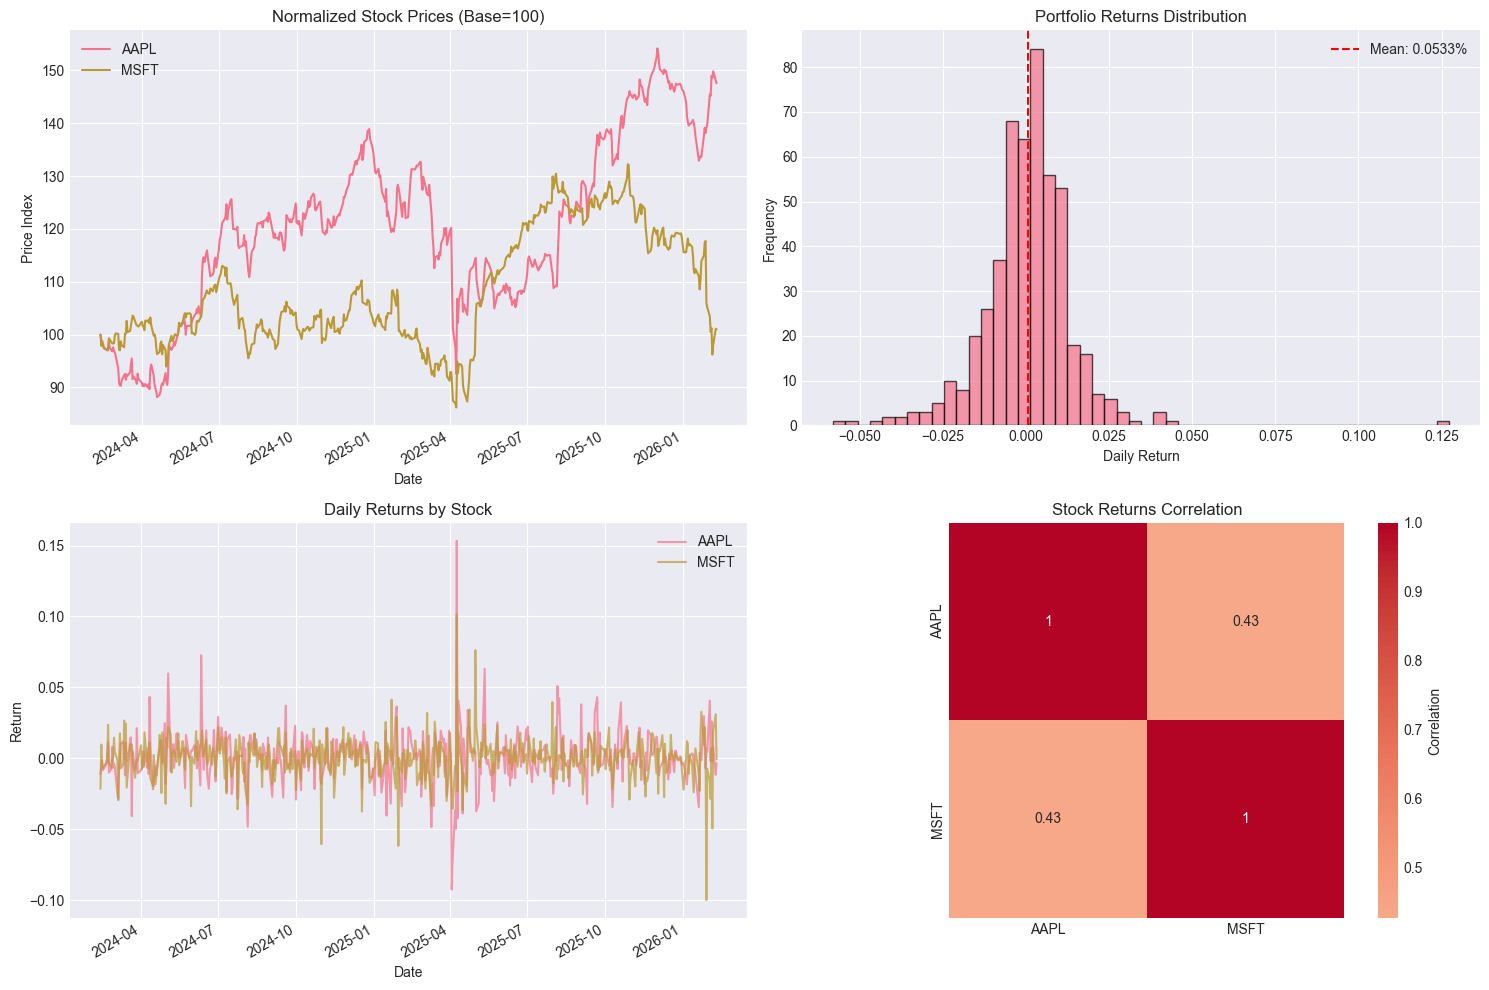


Correlation between AAPL and MSFT: 0.4262


In [27]:
# Visualize stock prices and returns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Normalized stock prices
normalized_prices = data / data.iloc[0] * 100
normalized_prices.plot(ax=axes[0, 0], title='Normalized Stock Prices (Base=100)')
axes[0, 0].set_ylabel('Price Index')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Portfolio returns distribution
axes[0, 1].hist(portfolio_returns, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Portfolio Returns Distribution')
axes[0, 1].set_xlabel('Daily Return')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(mean_return, color='r', linestyle='--', label=f'Mean: {mean_return:.4%}')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Individual stock returns
returns.plot(ax=axes[1, 0], alpha=0.7, title='Daily Returns by Stock')
axes[1, 0].set_ylabel('Return')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Correlation heatmap
correlation = returns.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[1, 1], cbar_kws={'label': 'Correlation'})
axes[1, 1].set_title('Stock Returns Correlation')

plt.tight_layout()
plt.show()

print(f"\nCorrelation between {tickers[0]} and {tickers[1]}: {correlation.iloc[0, 1]:.4f}")

## 4. Method 1: Historical VaR

The historical method uses actual historical returns to estimate VaR. It assumes that past performance is indicative of future risk.

In [28]:
def calculate_historical_var(returns, confidence_level, investment):
    """
    Calculate VaR using Historical Method
    """
    # Sort returns and find the percentile
    sorted_returns = np.sort(returns)
    index = int((1 - confidence_level) * len(sorted_returns))
    var_return = sorted_returns[index]
    var_dollar = investment * var_return
    
    return var_return, var_dollar

# Calculate Historical VaR
hist_var_return, hist_var_dollar = calculate_historical_var(
    portfolio_returns, confidence_level, initial_investment
)

print("=" * 60)
print("METHOD 1: HISTORICAL VaR")
print("=" * 60)
print(f"Confidence Level: {confidence_level:.0%}")
print(f"VaR (Return): {hist_var_return:.4%}")
print(f"VaR (Dollar): ${abs(hist_var_dollar):,.2f}")
print(f"\nInterpretation: With {confidence_level:.0%} confidence, the portfolio will not lose")
print(f"more than ${abs(hist_var_dollar):,.2f} in a single day.")
print("=" * 60)

METHOD 1: HISTORICAL VaR
Confidence Level: 95%
VaR (Return): -2.1302%
VaR (Dollar): $2,130.23

Interpretation: With 95% confidence, the portfolio will not lose
more than $2,130.23 in a single day.


## 5. Method 2: Variance-Covariance (Parametric) VaR

This method assumes returns are normally distributed and uses the mean and standard deviation to calculate VaR.

In [29]:
def calculate_parametric_var(mean, std, confidence_level, investment, time_horizon=1):
    """
    Calculate VaR using Variance-Covariance (Parametric) Method
    """
    # Z-score for confidence level
    z_score = stats.norm.ppf(1 - confidence_level)
    
    # VaR calculation
    var_return = mean + z_score * std * np.sqrt(time_horizon)
    var_dollar = investment * var_return
    
    return var_return, var_dollar, z_score

# Calculate Parametric VaR
param_var_return, param_var_dollar, z_score = calculate_parametric_var(
    mean_return, std_return, confidence_level, initial_investment
)

print("=" * 60)
print("METHOD 2: VARIANCE-COVARIANCE (PARAMETRIC) VaR")
print("=" * 60)
print(f"Confidence Level: {confidence_level:.0%}")
print(f"Z-Score: {z_score:.4f}")
print(f"Mean Return: {mean_return:.4%}")
print(f"Std Deviation: {std_return:.4%}")
print(f"VaR (Return): {param_var_return:.4%}")
print(f"VaR (Dollar): ${abs(param_var_dollar):,.2f}")
print(f"\nInterpretation: With {confidence_level:.0%} confidence, the portfolio will not lose")
print(f"more than ${abs(param_var_dollar):,.2f} in a single day.")
print("=" * 60)

METHOD 2: VARIANCE-COVARIANCE (PARAMETRIC) VaR
Confidence Level: 95%
Z-Score: -1.6449
Mean Return: 0.0533%
Std Deviation: 1.3846%
VaR (Return): -2.2242%
VaR (Dollar): $2,224.19

Interpretation: With 95% confidence, the portfolio will not lose
more than $2,224.19 in a single day.


## 6. Method 3: Monte Carlo Simulation VaR

This method uses random sampling to simulate thousands of possible future portfolio returns based on historical statistics.

In [30]:
def calculate_monte_carlo_var(returns, weights, confidence_level, investment, 
                               n_simulations=10000, time_horizon=1):
    """
    Calculate VaR using Monte Carlo Simulation
    """
    # Calculate mean returns and covariance matrix
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    # Cholesky decomposition for correlated random variables
    L = np.linalg.cholesky(cov_matrix)
    
    # Run Monte Carlo simulations
    simulated_returns = []
    
    for _ in range(n_simulations):
        # Generate random returns
        random_returns = np.random.normal(0, 1, len(weights))
        correlated_returns = mean_returns.values + np.dot(L, random_returns)
        
        # Calculate portfolio return
        portfolio_return = np.dot(weights, correlated_returns)
        simulated_returns.append(portfolio_return)
    
    simulated_returns = np.array(simulated_returns)
    
    # Calculate VaR
    var_return = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    var_dollar = investment * var_return
    
    return var_return, var_dollar, simulated_returns

# Calculate Monte Carlo VaR
print("Running Monte Carlo Simulation with 10,000 iterations...")
mc_var_return, mc_var_dollar, simulated_returns = calculate_monte_carlo_var(
    returns, weights, confidence_level, initial_investment, n_simulations=10000
)

print("\n" + "=" * 60)
print("METHOD 3: MONTE CARLO SIMULATION VaR")
print("=" * 60)
print(f"Confidence Level: {confidence_level:.0%}")
print(f"Number of Simulations: 10,000")
print(f"VaR (Return): {mc_var_return:.4%}")
print(f"VaR (Dollar): ${abs(mc_var_dollar):,.2f}")
print(f"\nInterpretation: With {confidence_level:.0%} confidence, the portfolio will not lose")
print(f"more than ${abs(mc_var_dollar):,.2f} in a single day.")
print("=" * 60)

Running Monte Carlo Simulation with 10,000 iterations...

METHOD 3: MONTE CARLO SIMULATION VaR
Confidence Level: 95%
Number of Simulations: 10,000
VaR (Return): -2.1969%
VaR (Dollar): $2,196.86

Interpretation: With 95% confidence, the portfolio will not lose
more than $2,196.86 in a single day.


## 7. Comparison of All Three Methods

In [31]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Method': ['Historical', 'Variance-Covariance', 'Monte Carlo'],
    'VaR (%)': [hist_var_return * 100, param_var_return * 100, mc_var_return * 100],
    'VaR ($)': [hist_var_dollar, param_var_dollar, mc_var_dollar],
    'VaR (Absolute $)': [abs(hist_var_dollar), abs(param_var_dollar), abs(mc_var_dollar)]
})

print("\n" + "=" * 80)
print("VaR COMPARISON - ALL THREE METHODS")
print("=" * 80)
print(f"Portfolio Value: ${initial_investment:,.2f}")
print(f"Confidence Level: {confidence_level:.0%}")
print(f"Time Horizon: 1 day")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Calculate differences
print("\nDifferences Between Methods:")
print(f"Historical vs Parametric: ${abs(hist_var_dollar - param_var_dollar):,.2f}")
print(f"Historical vs Monte Carlo: ${abs(hist_var_dollar - mc_var_dollar):,.2f}")
print(f"Parametric vs Monte Carlo: ${abs(param_var_dollar - mc_var_dollar):,.2f}")


VaR COMPARISON - ALL THREE METHODS
Portfolio Value: $100,000.00
Confidence Level: 95%
Time Horizon: 1 day
             Method   VaR (%)      VaR ($)  VaR (Absolute $)
         Historical -2.130226 -2130.225844       2130.225844
Variance-Covariance -2.224194 -2224.194392       2224.194392
        Monte Carlo -2.196859 -2196.858924       2196.858924

Differences Between Methods:
Historical vs Parametric: $93.97
Historical vs Monte Carlo: $66.63
Parametric vs Monte Carlo: $27.34


## 8. Visualize VaR Comparison

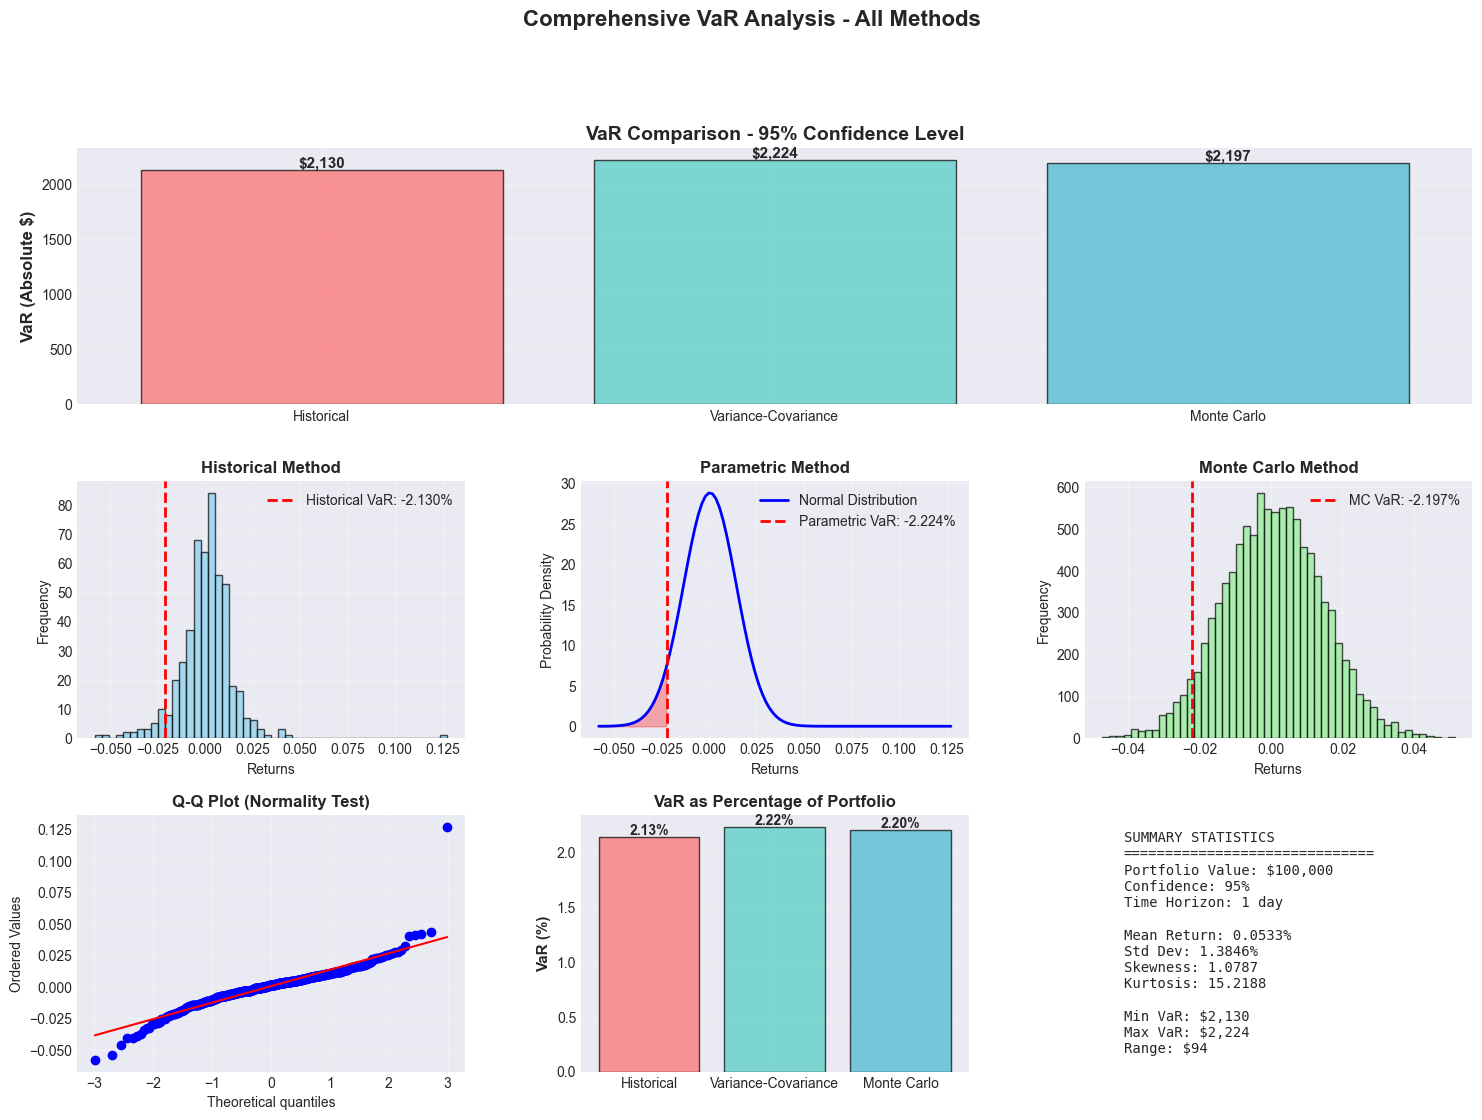

In [32]:
# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Bar chart comparing VaR values
ax1 = fig.add_subplot(gs[0, :])
methods = comparison_df['Method']
var_values = comparison_df['VaR (Absolute $)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax1.bar(methods, var_values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('VaR (Absolute $)', fontsize=12, fontweight='bold')
ax1.set_title(f'VaR Comparison - {confidence_level:.0%} Confidence Level', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Historical distribution with VaR
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(portfolio_returns, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(hist_var_return, color='red', linestyle='--', linewidth=2, 
            label=f'Historical VaR: {hist_var_return:.3%}')
ax2.set_xlabel('Returns', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('Historical Method', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Normal distribution with VaR
ax3 = fig.add_subplot(gs[1, 1])
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 100)
ax3.plot(x, stats.norm.pdf(x, mean_return, std_return), 'b-', linewidth=2, 
         label='Normal Distribution')
ax3.axvline(param_var_return, color='red', linestyle='--', linewidth=2, 
            label=f'Parametric VaR: {param_var_return:.3%}')
ax3.fill_between(x, 0, stats.norm.pdf(x, mean_return, std_return), 
                 where=(x <= param_var_return), alpha=0.3, color='red')
ax3.set_xlabel('Returns', fontsize=10)
ax3.set_ylabel('Probability Density', fontsize=10)
ax3.set_title('Parametric Method', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Monte Carlo distribution with VaR
ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(simulated_returns, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax4.axvline(mc_var_return, color='red', linestyle='--', linewidth=2, 
            label=f'MC VaR: {mc_var_return:.3%}')
ax4.set_xlabel('Returns', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title('Monte Carlo Method', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Q-Q plot for normality test
ax5 = fig.add_subplot(gs[2, 0])
stats.probplot(portfolio_returns, dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot (Normality Test)', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Percentage comparison
ax6 = fig.add_subplot(gs[2, 1])
var_percentages = comparison_df['VaR (%)'].abs()
bars2 = ax6.bar(methods, var_percentages, color=colors, alpha=0.7, edgecolor='black')
ax6.set_ylabel('VaR (%)', fontsize=11, fontweight='bold')
ax6.set_title('VaR as Percentage of Portfolio', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 7. Summary statistics table
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
summary_text = f"""
SUMMARY STATISTICS
{'='*30}
Portfolio Value: ${initial_investment:,.0f}
Confidence: {confidence_level:.0%}
Time Horizon: 1 day

Mean Return: {mean_return:.4%}
Std Dev: {std_return:.4%}
Skewness: {portfolio_returns.skew():.4f}
Kurtosis: {portfolio_returns.kurtosis():.4f}

Min VaR: ${comparison_df['VaR (Absolute $)'].min():,.0f}
Max VaR: ${comparison_df['VaR (Absolute $)'].max():,.0f}
Range: ${comparison_df['VaR (Absolute $)'].max() - comparison_df['VaR (Absolute $)'].min():,.0f}
"""
ax7.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center')

plt.suptitle('Comprehensive VaR Analysis - All Methods', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

## 9. Statistical Analysis and Method Comparison

In [33]:
# Test for normality
from scipy.stats import shapiro, jarque_bera

shapiro_stat, shapiro_p = shapiro(portfolio_returns)
jb_stat, jb_p = jarque_bera(portfolio_returns)

print("=" * 80)
print("STATISTICAL TESTS")
print("=" * 80)
print("\nNormality Tests:")
print(f"Shapiro-Wilk Test: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
print(f"Jarque-Bera Test: statistic={jb_stat:.4f}, p-value={jb_p:.4f}")

if shapiro_p < 0.05:
    print("\n⚠ Returns are NOT normally distributed (p < 0.05)")
    print("→ Historical and Monte Carlo methods may be more reliable")
else:
    print("\n✓ Returns appear normally distributed (p >= 0.05)")
    print("→ Parametric method assumptions are reasonable")

# Distribution characteristics
print("\nDistribution Characteristics:")
print(f"Skewness: {portfolio_returns.skew():.4f}")
print(f"Kurtosis: {portfolio_returns.kurtosis():.4f}")

if abs(portfolio_returns.skew()) > 0.5:
    print("→ Distribution is skewed (may have fat tails)")
if portfolio_returns.kurtosis() > 3:
    print("→ Distribution has heavier tails than normal (leptokurtic)")

print("\n" + "=" * 80)

STATISTICAL TESTS

Normality Tests:
Shapiro-Wilk Test: statistic=0.8879, p-value=0.0000
Jarque-Bera Test: statistic=4818.3884, p-value=0.0000

⚠ Returns are NOT normally distributed (p < 0.05)
→ Historical and Monte Carlo methods may be more reliable

Distribution Characteristics:
Skewness: 1.0787
Kurtosis: 15.2188
→ Distribution is skewed (may have fat tails)
→ Distribution has heavier tails than normal (leptokurtic)



## 10. Backtesting VaR Models

In [34]:
# Backtest: Count how many times actual loss exceeded VaR
def backtest_var(returns, var_return, confidence_level):
    """
    Backtest VaR model by counting exceptions (actual losses > VaR)
    """
    exceptions = returns < var_return
    num_exceptions = exceptions.sum()
    total_days = len(returns)
    exception_rate = num_exceptions / total_days
    expected_rate = 1 - confidence_level
    
    return num_exceptions, total_days, exception_rate, expected_rate

print("=" * 80)
print("BACKTESTING RESULTS")
print("=" * 80)

methods_data = [
    ('Historical', hist_var_return),
    ('Parametric', param_var_return),
    ('Monte Carlo', mc_var_return)
]

backtest_results = []

for method_name, var_return in methods_data:
    num_ex, total, ex_rate, exp_rate = backtest_var(
        portfolio_returns, var_return, confidence_level
    )
    
    backtest_results.append({
        'Method': method_name,
        'Exceptions': num_ex,
        'Total Days': total,
        'Exception Rate': f"{ex_rate:.2%}",
        'Expected Rate': f"{exp_rate:.2%}",
        'Difference': f"{(ex_rate - exp_rate):.2%}"
    })
    
    print(f"\n{method_name} Method:")
    print(f"  Exceptions: {num_ex} out of {total} days")
    print(f"  Actual exception rate: {ex_rate:.2%}")
    print(f"  Expected exception rate: {exp_rate:.2%}")
    print(f"  Difference: {(ex_rate - exp_rate):.2%}")
    
    if abs(ex_rate - exp_rate) < 0.01:
        print("  ✓ Model performance: GOOD")
    elif abs(ex_rate - exp_rate) < 0.02:
        print("  ⚠ Model performance: ACCEPTABLE")
    else:
        print("  ✗ Model performance: NEEDS CALIBRATION")

print("\n" + "=" * 80)

backtest_df = pd.DataFrame(backtest_results)
print("\n" + backtest_df.to_string(index=False))

BACKTESTING RESULTS

Historical Method:
  Exceptions: 25 out of 500 days
  Actual exception rate: 5.00%
  Expected exception rate: 5.00%
  Difference: -0.00%
  ✓ Model performance: GOOD

Parametric Method:
  Exceptions: 22 out of 500 days
  Actual exception rate: 4.40%
  Expected exception rate: 5.00%
  Difference: -0.60%
  ✓ Model performance: GOOD

Monte Carlo Method:
  Exceptions: 23 out of 500 days
  Actual exception rate: 4.60%
  Expected exception rate: 5.00%
  Difference: -0.40%
  ✓ Model performance: GOOD


     Method  Exceptions  Total Days Exception Rate Expected Rate Difference
 Historical          25         500          5.00%         5.00%     -0.00%
 Parametric          22         500          4.40%         5.00%     -0.60%
Monte Carlo          23         500          4.60%         5.00%     -0.40%


## 11. Key Insights and Recommendations

In [35]:
print("=" * 80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("=" * 80)

print("\n1. METHOD COMPARISON:")
print("   • Historical VaR: Uses actual past data, no distributional assumptions")
print("   • Parametric VaR: Fast, assumes normal distribution")
print("   • Monte Carlo VaR: Flexible, captures non-linear relationships")

print("\n2. WHEN TO USE EACH METHOD:")
print("   • Historical: When you have sufficient historical data and believe")
print("                 past patterns will continue")
print("   • Parametric: When returns are normally distributed and you need")
print("                 quick calculations")
print("   • Monte Carlo: For complex portfolios with options/derivatives or")
print("                  non-normal distributions")

print("\n3. LIMITATIONS:")
print("   • Historical: Limited by available data, may not capture future events")
print("   • Parametric: Assumes normality, underestimates tail risk")
print("   • Monte Carlo: Computationally intensive, results vary with each run")

print("\n4. BEST PRACTICES:")
print("   • Use multiple methods and compare results")
print("   • Regularly backtest VaR models")
print("   • Adjust for changing market conditions")
print("   • Consider stress testing and scenario analysis")
print("   • Remember: VaR only tells you the minimum loss at the confidence level")

print("\n" + "=" * 80)

# Determine which method gave most conservative (highest) VaR
most_conservative = comparison_df.loc[comparison_df['VaR (Absolute $)'].idxmax(), 'Method']
least_conservative = comparison_df.loc[comparison_df['VaR (Absolute $)'].idxmin(), 'Method']

print(f"\n📊 ANALYSIS FOR THIS PORTFOLIO:")
print(f"   Most Conservative: {most_conservative} Method")
print(f"   Least Conservative: {least_conservative} Method")
print(f"   Range: ${comparison_df['VaR (Absolute $)'].max() - comparison_df['VaR (Absolute $)'].min():,.2f}")
print("\n" + "=" * 80)

KEY INSIGHTS AND RECOMMENDATIONS

1. METHOD COMPARISON:
   • Historical VaR: Uses actual past data, no distributional assumptions
   • Parametric VaR: Fast, assumes normal distribution
   • Monte Carlo VaR: Flexible, captures non-linear relationships

2. WHEN TO USE EACH METHOD:
   • Historical: When you have sufficient historical data and believe
                 past patterns will continue
   • Parametric: When returns are normally distributed and you need
                 quick calculations
   • Monte Carlo: For complex portfolios with options/derivatives or
                  non-normal distributions

3. LIMITATIONS:
   • Historical: Limited by available data, may not capture future events
   • Parametric: Assumes normality, underestimates tail risk
   • Monte Carlo: Computationally intensive, results vary with each run

4. BEST PRACTICES:
   • Use multiple methods and compare results
   • Regularly backtest VaR models
   • Adjust for changing market conditions
   • Consider stress 

## 12. Export Results

In [36]:
# Create comprehensive results DataFrame
results_summary = pd.DataFrame({
    'Metric': ['Portfolio Value', 'Confidence Level', 'Mean Daily Return', 
               'Daily Volatility', 'Annualized Return', 'Annualized Volatility'],
    'Value': [f'${initial_investment:,.2f}', f'{confidence_level:.0%}', 
              f'{mean_return:.4%}', f'{std_return:.4%}',
              f'{mean_return * 252:.2%}', f'{std_return * np.sqrt(252):.2%}']
})

# Save to CSV
comparison_df.to_csv('var_comparison.csv', index=False)
results_summary.to_csv('portfolio_summary.csv', index=False)

print("✓ Results exported to CSV files:")
print("  • var_comparison.csv")
print("  • portfolio_summary.csv")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)

✓ Results exported to CSV files:
  • var_comparison.csv
  • portfolio_summary.csv

ANALYSIS COMPLETE!
